In [1]:
import os
import yaml
import warnings
import pickle
import random

from cachetools import cached
from itertools import product

import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from PIL import Image
from matplotlib import pyplot as plt

from netconfig import NetConfig

np.set_printoptions(precision=4)
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.debugging.set_log_device_placement(False)
tf.random.set_seed(42)

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.12.0


# Training Configuration
Set `SELECTED_MODEL` to `None` to perform a parameter search, or set it
to a `NetConfig` object with the chosen configuration

In [2]:
LABELS_PATH="/workspaces/motion/labels.yaml"
IMAGES_BASE="/workspaces/motion/images/esp32/good"
DISCARD_IMAGES_DIR="/workspaces/motion/images/esp32/discard"
MODEL_PATH = "./output"
BATCH_SIZE=64

SELECTED_MODEL=None
SELECTED_MODEL=NetConfig(conv_per_layer1=16, conv_kernel_shape1=(5, 5), conv_kernel_shape2=(5, 5), dropout1=0.6578667934018374, dense_size=128)


# Load labels globally

In [3]:
with open(LABELS_PATH) as f:
    label_map = yaml.load(f, Loader=yaml.SafeLoader)["labels"]
reverse_label_map = {v:k for k,v in label_map.items()}

# Utility functions

In [4]:
def tf_init():
  # Taken from tensorflow GPU docs
  # https://www.tensorflow.org/guide/gpu
  gpus = tf.config.list_physical_devices('GPU')
  if gpus:
    try:
      # Currently, memory growth needs to be the same across GPUs
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        # tf.config.experimental.set_virtual_device_configuration(
        #   gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
        # )
      logical_gpus = tf.config.list_logical_devices('GPU')
      print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

@cached(cache={})
def load_train_data():
    examples = []
    examples_labels = []
    for dir,_,files in os.walk(IMAGES_BASE):
        for file in files:
            examples.append(np.asarray(Image.open(os.path.join(dir, file)).point(lambda x: 255 if x>0 else 0), dtype=np.float32).reshape(29, 40, 1))
            examples_labels.append(label_map[os.path.basename(dir)])
    examples_numpy = np.asarray(examples)
    examples_labels_numpy = np.asanyarray(examples_labels)

    ds = tf.data.Dataset.from_tensor_slices((examples_numpy, examples_labels_numpy))
    ds = ds.shuffle(buffer_size=2000, reshuffle_each_iteration=False).batch(BATCH_SIZE)

    val_ds = ds.take(2)
    test_ds = ds.skip(2).take(2)
    train_ds = ds.skip(4)

    return (train_ds, val_ds, test_ds)

@cached(cache={})
def load_discard_images():
    discard_files = []
    garbage_image_arrays = []
    for dir,_,files in os.walk(DISCARD_IMAGES_DIR):
        for file in files:
            discard_files.append(os.path.join(dir, file))

    for imgfile in discard_files:
        i = Image.open(imgfile).point(lambda x: 255 if x>0 else 0)
        garbage_img_array = np.asarray(i, dtype=np.float32).reshape(29,40, 1)
        garbage_image_arrays.append(garbage_img_array)

    all_garbage_images = np.array(garbage_image_arrays)
    garbage_ds = tf.data.Dataset.from_tensor_slices(all_garbage_images)

    return garbage_ds.batch(BATCH_SIZE)

# Model config generator for parameter searches
The variables at the top of the generator define the parameter grid.
See the definition of NetConfig in `netconfig.py` for all the fields.  I pulled
the definition of that object class out to its own module because it was less problematic
when I tried to pickle, unpickle things containing objects of that class.

In [5]:
def generate_floats(k, min_val, max_val):
    """
    Courtesy of ChatGPT
    """
    result = []
    interval = (max_val - min_val) / k

    for i in range(k):
        result.append(min_val + i * interval + random.uniform(0, interval))
        
    return result

def config_generator():
  conv_per_layer1 = [8, 12, 16]
  conv_kernel_shape1 = [(3,3), (5,5)]
  conv_kernel_shape2 = [(3,3), (5,5)]
  dropout1 = generate_floats(4, .6, .85)
  dense_size = [64, 128, 256]

  grid = [
    conv_per_layer1,
    conv_kernel_shape1,
    conv_kernel_shape2,
    dropout1,
    dense_size
  ]

  for c in product(*grid):
    yield NetConfig(
      conv_per_layer1=c[0],
      conv_kernel_shape1=c[1],
      conv_kernel_shape2=c[2],
      dropout1=c[3],
      dense_size=c[4]
    )

# Build a network and train a model according to a passed NetConfig
This returns the Tensorflow History object from the call to fit().  You can get
the model in the `model` attribute of this object.

In [6]:
def generate_model(config: NetConfig, train_ds, val_ds):
  layers = []
  layers = [
    tf.keras.layers.Conv2D(filters=config.conv_per_layer1, kernel_size=config.conv_kernel_shape1, padding='same', activation='relu', input_shape=(29,40,1)), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=config.conv_per_layer1*2, kernel_size=config.conv_kernel_shape1, padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(config.dropout1),
    tf.keras.layers.Dense(config.dense_size, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
  ]
  model = tf.keras.models.Sequential(layers)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

  log_dir = "/workspaces/motion/logs/fit/"
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  stoping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=100
  )

  history = model.fit(
      train_ds,
      epochs=200,
      validation_data=val_ds,
      callbacks=[
        stoping_callback,
        tensorboard_callback
      ],
      verbose=0,
  )
  return history

# Functions for parameter search

In [7]:
def train_and_evaluate_model(c: NetConfig):
    (train_ds, val_ds, test_ds) = load_train_data()
    h = generate_model(c, train_ds, val_ds)
    model = h.model

    real_classes = []
    pred_classes = []
    count_high_prob = 0

    for batch in test_ds:
        preds = model.predict(batch[0], verbose=0)
        tmp_max_value = np.amax(preds, axis=1)
        count_high_prob += np.count_nonzero(tmp_max_value > .8)
        pred_classes.extend(tf.argmax(preds, axis=1).numpy())
        real_classes.extend(batch[1].numpy())

    weighted_f1 = f1_score(real_classes, pred_classes, average='weighted')
    micro_f1 = f1_score(real_classes, pred_classes, average='micro')
    macro_f1 = f1_score(real_classes, pred_classes, average='macro')

    discard_images = load_discard_images()
    preds = model.predict(discard_images, verbose=0)
    max_value = np.amax(preds, axis=1)
    high_prob_crap_percent = (np.count_nonzero(max_value > .8)/len(max_value))*100
    ret =  {
        'model': model,
        'history': h.history,
        'config': c,
        'weighted_f1': weighted_f1,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'high_prob_good_percent': (count_high_prob/len(pred_classes))*100,
        'high_prob_crap_percent': high_prob_crap_percent
    }
    ret.update({k: v[29] for k,v in h.history.items()})
    return ret

def param_search():
    tf_init()
    rets = []
    configs = [c for c in config_generator()]
    for c in tqdm(configs):
        r = train_and_evaluate_model(c)
        del r['model']
        print(r['config'])
        rets.append(r)

    with open("param_results.p", "wb") as f:
        pickle.dump(rets, f)

# Network parameter/config search
This will run if `SELECTED_MODEL` is set to `None` at the top of this notebook

In [8]:
if not SELECTED_MODEL:
    param_search()

# Functions for evaluating a single chosen model

In [9]:
def confusion_matrix_for_model(model, test_ds):
    real_classes = []
    pred_classes = []

    for batch in test_ds:
        preds = model.predict(batch[0], verbose=0)
        pred_classes.extend(tf.argmax(preds, axis=1).numpy())
        real_classes.extend(batch[1].numpy())

    weighted_f1 = f1_score(real_classes, pred_classes, average='weighted')
    conf_matrix = tf.math.confusion_matrix(real_classes, pred_classes)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.gray, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j].numpy(), va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title(f'Confusion Matrix (weighted F1: {weighted_f1})', fontsize=18)

    return plt

def discard_histogram_for_model(model, discard_ds):
    preds = model.predict(discard_ds, verbose=0)
    max_arg = np.argmax(preds, axis=1)
    max_value = np.amax(preds, axis=1)
    bad_args = max_arg[max_value > .95]

    high_prob_crap_percent = (np.count_nonzero(max_value > .95)/len(max_value))*100

    ax = sns.histplot(
        bad_args,
    )
    ax.set_title(
        f"High probability predictions on discard pile\n({high_prob_crap_percent}%)"
    )
    ax.set_xlim(0,len(label_map)-1)
    ax.set_xticks(range(0,len(label_map)))
    return ax

# Fit Model

In [10]:
if SELECTED_MODEL:
    (train_ds, val_ds, test_ds) = load_train_data()
    discard_ds = load_discard_images()
    history = generate_model(SELECTED_MODEL, train_ds=train_ds, val_ds=val_ds)
    history.model.save(MODEL_PATH)

24
Restoring model weights from the end of the best epoch: 104.
Epoch 114: early stopping


INFO:tensorflow:Assets written to: ./output/assets


INFO:tensorflow:Assets written to: ./output/assets


In [11]:
if SELECTED_MODEL:
    history.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 40, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 20, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 16, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0

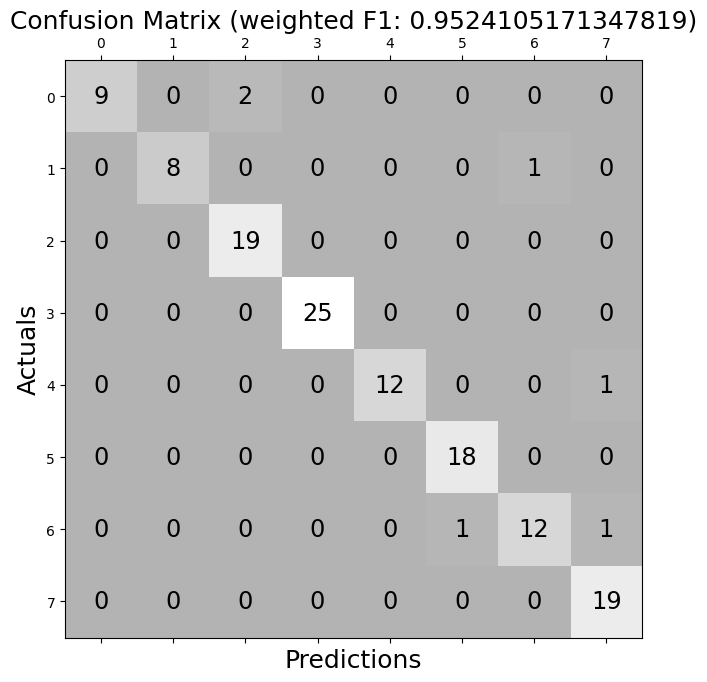

In [12]:
if SELECTED_MODEL:
    confusion_matrix_for_model(history.model, test_ds=test_ds)

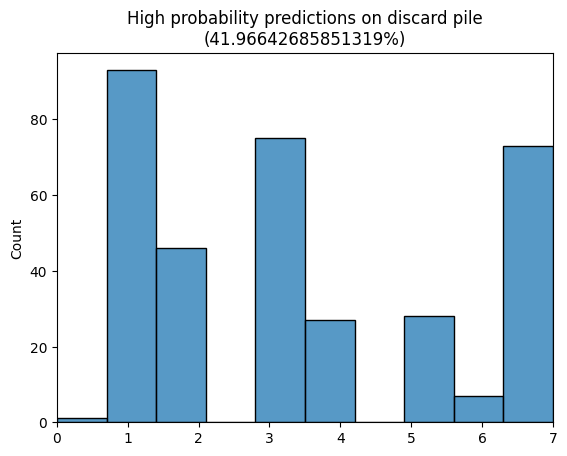

In [13]:
if SELECTED_MODEL:
    discard_histogram_for_model(history.model, discard_ds=discard_ds)

# TFLite Conversion
This expects the TF model to be in `./output`

In [14]:
if SELECTED_MODEL:
    def representative_data_gen():
        (train_ds, _, _) = load_train_data()
        for batch in train_ds:
            yield [batch[0]]

    # Convert the model
    converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    tflite_model = converter.convert()

    # Save the model.
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)

fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


# Evaluate TFLite model the same way

In [15]:
class TFLiteModelWrapper:
    """
    Wrap a tflite model with something that provides a predict() method
    that works like a normal model so we can use our existing test functions
    against them
    """
    def __init__(self, path):
        self.interpreter = tf.lite.Interpreter(path)
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.interpreter.allocate_tensors()

    def predict(self, data, verbose=0):
        ret = []
        if not hasattr(data, 'shape'):
            # This is a batch dataset
            batches = [b for b in data]
        else:
            batches = [data]
        for batch in batches:
            for image in batch:
                expand_image = np.expand_dims(image, axis=0)
                self.interpreter.set_tensor(self.input_details[0]['index'], expand_image.astype(np.uint8))
                self.interpreter.invoke()
                output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
                # Scale back to a float so the comparison functions based on the
                # un-converted model will still work
                ret.append(output_data/255)

        return np.squeeze(np.array(ret))

tfl = TFLiteModelWrapper('model.tflite')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


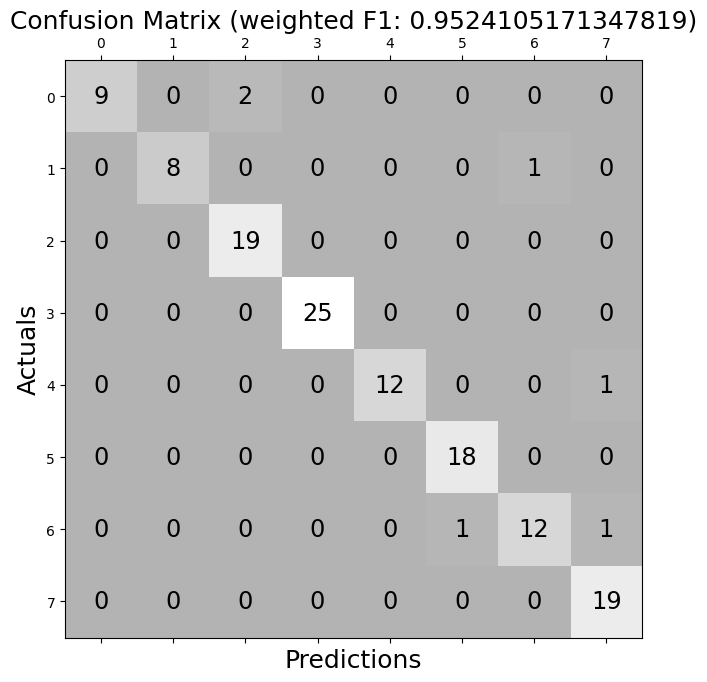

In [16]:
if SELECTED_MODEL:
    confusion_matrix_for_model(tfl, test_ds)

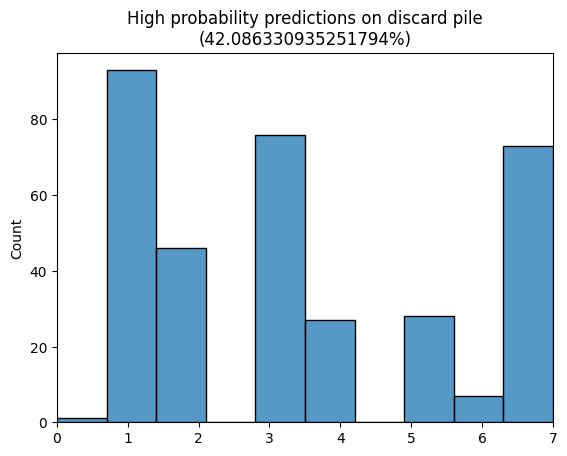

In [17]:
if SELECTED_MODEL:
    discard_histogram_for_model(tfl, discard_ds)

# Write out model CPP

In [21]:
if SELECTED_MODEL:
    model_hpp = """
    #ifndef _MODEL_H_
    #define _MODEL_H_

    extern const unsigned char model_tflite[];
    extern const unsigned int model_tflite_len;

    #endif // _MODEL_H_
    """
    with open("/workspaces/motion/esp32/wand/main/model.hpp", "w") as f:
        f.write(model_hpp)

    with open('model.tflite', 'rb') as f:
        d = f.read()

    BYTES_PER_LINE=15
    cpp_out = '#include "model.hpp"\n\n'
    cpp_out += 'alignas(8) const unsigned char model_tflite[] = {\n'
    (whole_lines, final_line_size) = divmod(len(d), BYTES_PER_LINE)
    for i in range(whole_lines):
        if final_line_size == 0 and i == whole_lines - 1:
            endchar = '\n};'
        else:
            endchar=','
        cpp_out += (' ' * 4) + ', '.join([f"0x{b:02x}" for b in d[i*BYTES_PER_LINE:(i*BYTES_PER_LINE)+BYTES_PER_LINE]]) + f'{endchar}\n'
    if final_line_size > 0:
        cpp_out += (' ' * 4) + ', '.join([f"0x{b:02x}" for b in d[whole_lines*BYTES_PER_LINE:]]) + '\n};\n'
    cpp_out += f"const unsigned int model_tflite_len = {len(d)};\n"

    with open("/workspaces/motion/esp32/wand/main/model.cpp", "w") as f:
        f.write(cpp_out)